In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter, gaussian_filter1d

from qsa_pwfa.three_function.simulation import Simulation
from qsa_pwfa.beams import GaussianBeam
from qsa_pwfa.utils import get_density, get_field, get_Psi_new_grid

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
"""
CASE 1

nb/n0 = 5
kp*sigma_r = 0.1
kp_sigma_z = 1r_axis
Lambda = 0.05)

CASE 3

n_b = 0.1
R_b = 0.1
ksi0 = 5.
R_xi = 0.1

# plasma
L_xi = 18.
L_r = 10/2.5

"""


# Beam 
n_b = 16.
R_b = 0.25
ksi0 = 5.
R_xi = 1.

# plasma
L_xi = 18.
L_r = 10.

# grid
N_xi = 4096
N_r = 2048

d_xi = L_xi / N_xi

dr = L_r / N_r

#d_xi = L_xi / N_xi
#dr = 0.03 * d_xi

#N_r = int(np.ceil(L_r/dr / 4)*4)
#L_r = N_r * dr
n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12

1197.4784654024647

In [3]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi, 
                 L_r=L_r, N_r=N_r, 
                 verbose=1)

beam_drv = GaussianBeam(n_b, R_b, ksi0, R_xi)
sim.add_beam(beam_drv)

In [4]:
r_xi = np.zeros((sim.N_xi, sim.N_r))
vz_xi = np.zeros((sim.N_xi, sim.N_r))
phi_xi = np.zeros((sim.N_xi, sim.N_r))
dAr_dxi_xi = np.zeros((sim.N_xi, sim.N_r))
dAz_dr_xi = np.zeros((sim.N_xi, sim.N_r))
force_xi = np.zeros((sim.N_xi, sim.N_r))

r_xi[0] = sim.r
vz_xi[0] = sim.v_z

for i_xi in tqdm(range(N_xi-1)):
    sim.advance_xi(iter_max=30, rel_err_max=1e-2, mixing_factor=0.05)
    r_xi[i_xi+1] = sim.r
    vz_xi[i_xi+1] = sim.v_z
    phi_xi[i_xi+1] = sim.Psi
    dAr_dxi_xi[i_xi+1] = sim.dAr_dxi
    dAz_dr_xi[i_xi+1] = sim.dAz_dr
    force_xi[i_xi+1] = sim.F

  0%|          | 0/4095 [00:00<?, ?it/s]

<ipython-input-5-16942e25b95a>:14: RuntimeWarning: invalid value encountered in true_divide
  val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))


<IPython.core.display.Javascript object>


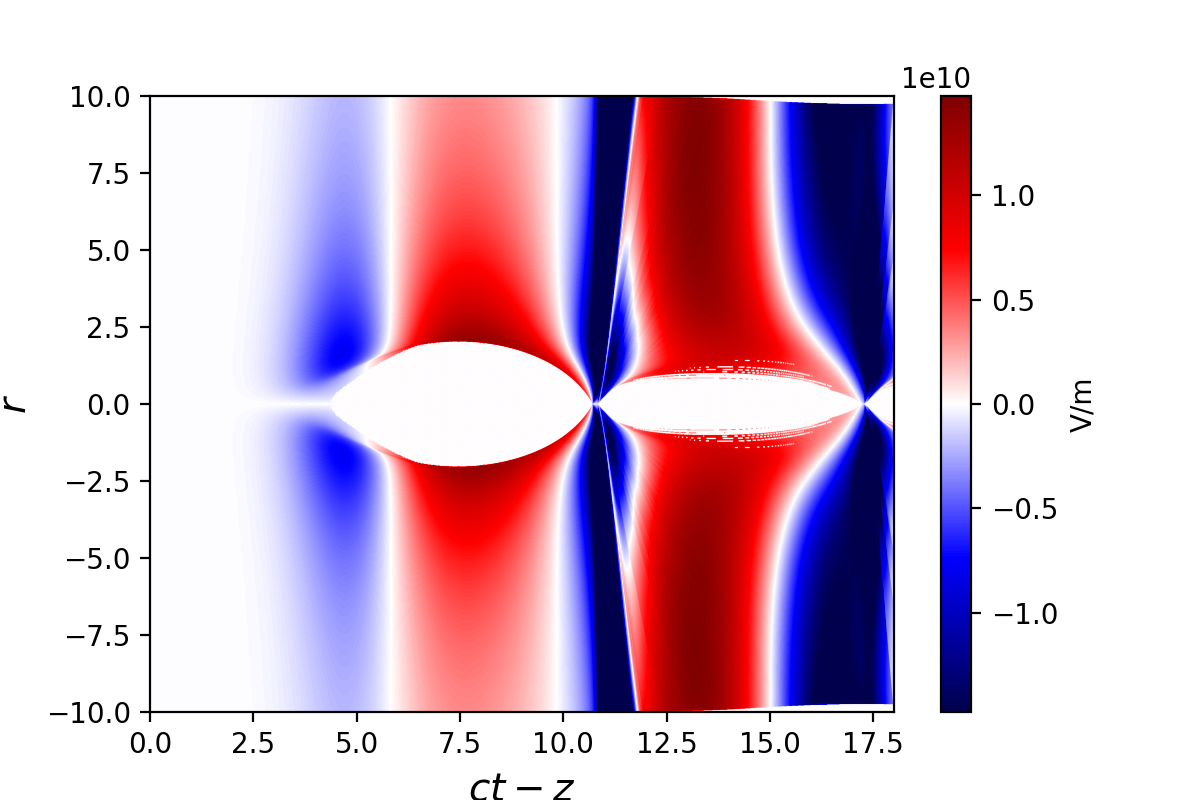

In [5]:
"""plt.figure()
plt.plot(sim.r0, force_xi[200], label = 'force')
plt.plot(sim.r0, force_diff[200], label = 'force_diff')
plt.legend()
#plt.savefig('diff_case.jpg')"""

Nr_new = sim.N_r//2
dr_proj = L_r/Nr_new
ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) # * k_p_inv * 1e6

for field_val in [ dAr_dxi_xi * (1 - vz_xi), ]:
    dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    field_dens = get_field(field_val, r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))    
    val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))
    
    plt.figure(figsize=(6,4))

    #vmax = np.abs( val.max() ) 
    vmax = np.abs( val.max() ) * field_dim   
    plt.imshow(val_ext.T*field_dim, origin='lower', 
               aspect='auto', cmap=plt.cm.seismic,
               vmax=vmax, vmin=-vmax,
               extent=ext)

    plt.colorbar(label='V/m')
    plt.xlabel(r'$ct-z$', fontsize=14)
    plt.ylabel(r'$r$', fontsize=14)


<IPython.core.display.Javascript object>


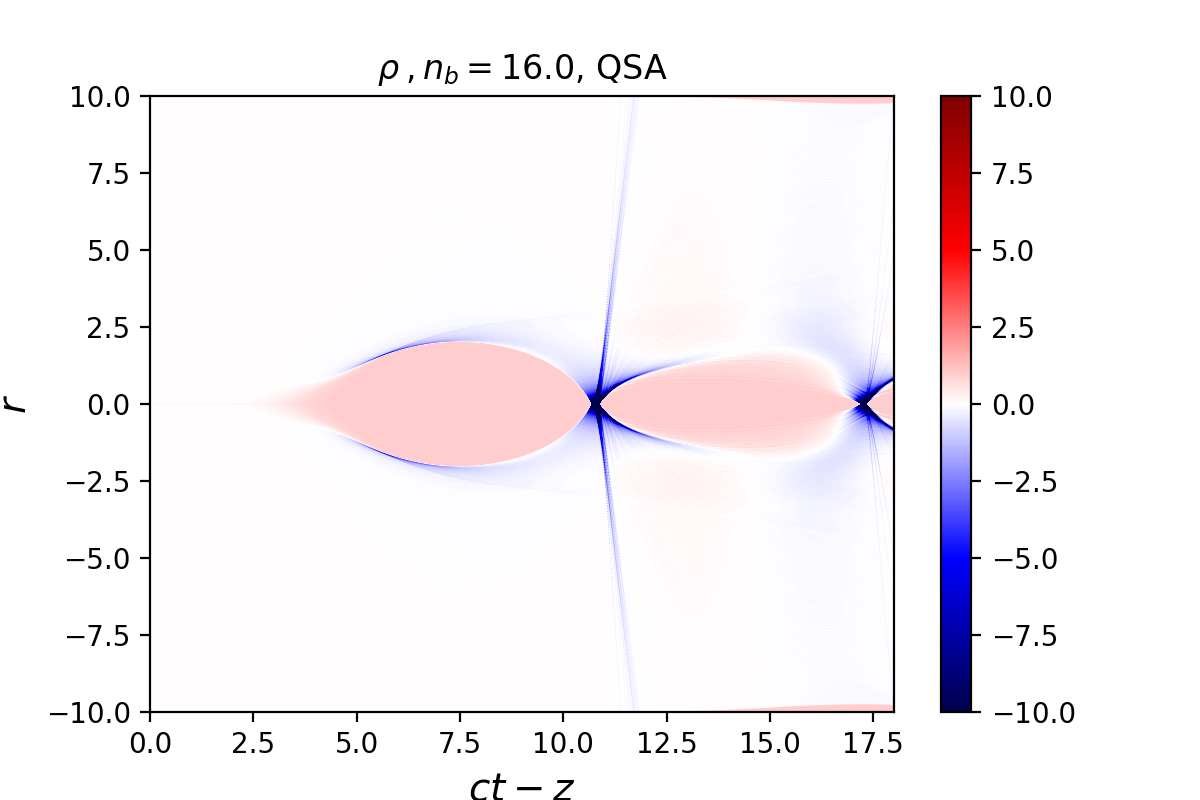

<ipython-input-6-a3825bc66e43>:33: RuntimeWarning: invalid value encountered in true_divide
  val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))


<IPython.core.display.Javascript object>


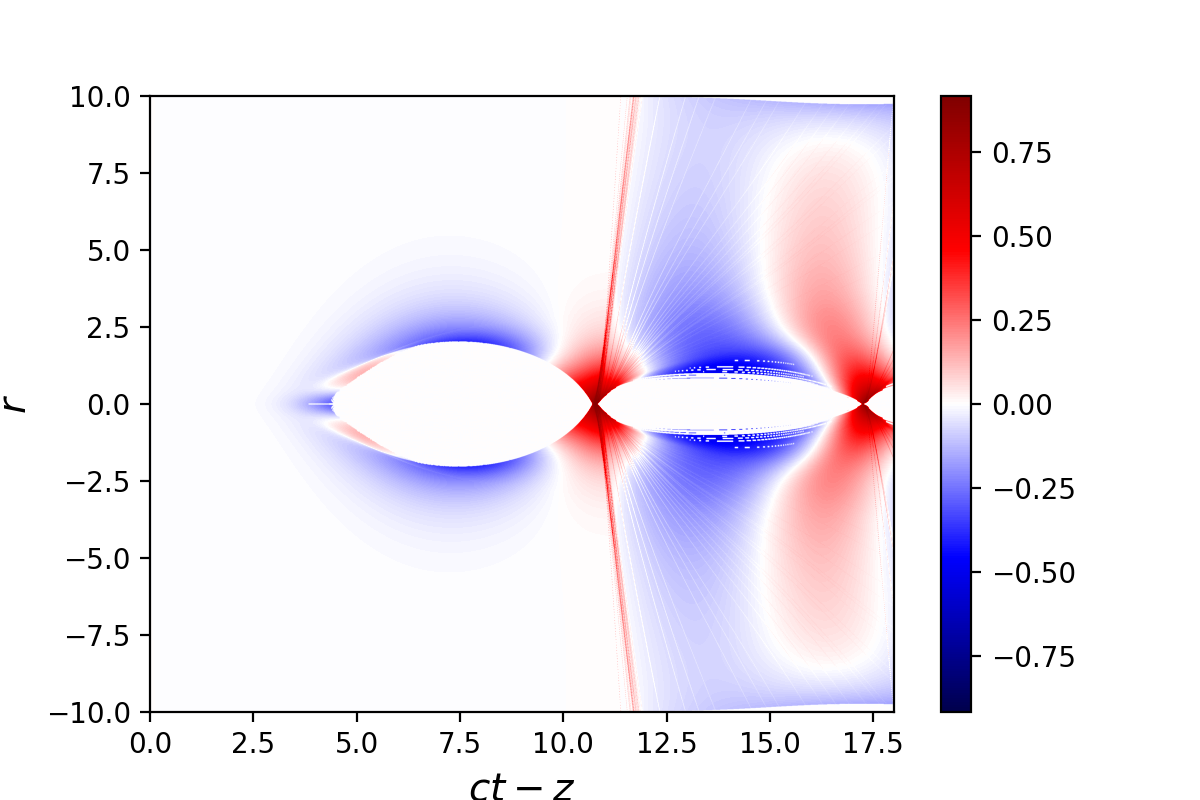

<IPython.core.display.Javascript object>


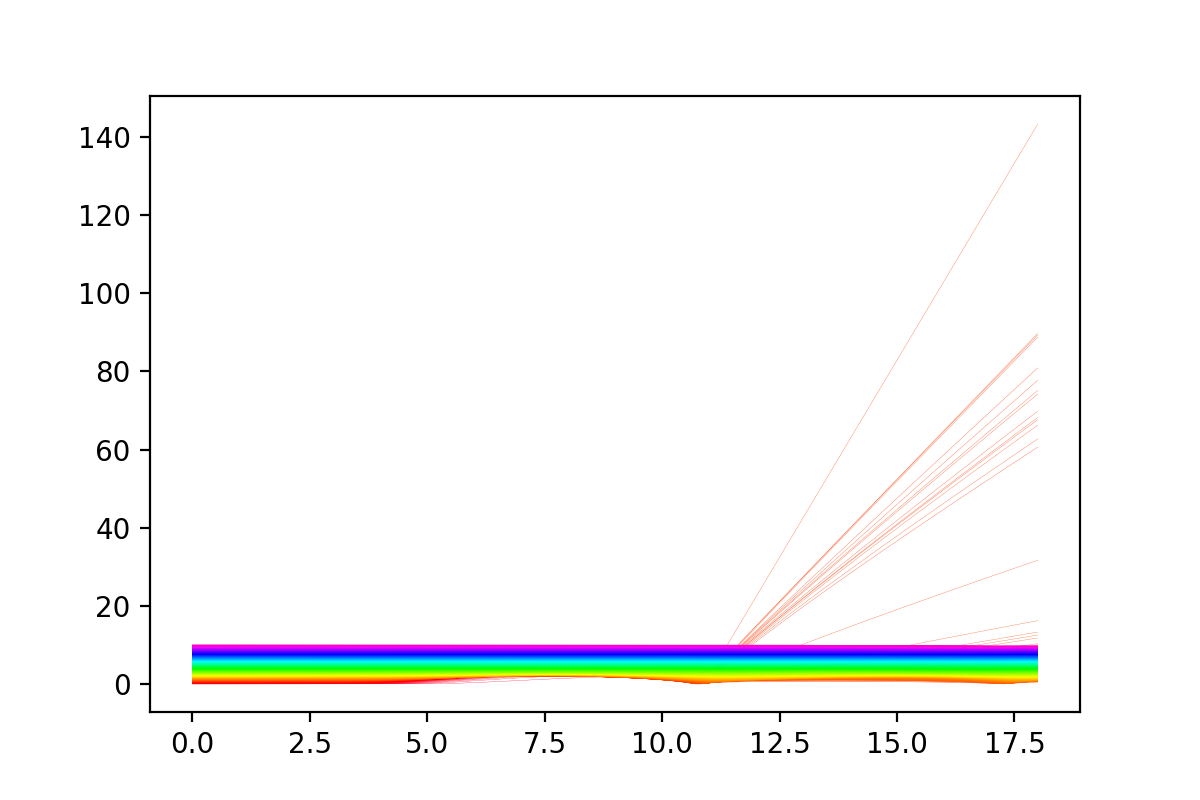

In [6]:
Nr_new = sim.N_r//2
dr_proj = L_r/Nr_new

dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
dens_ext = np.hstack((dens[:,1:][:,::-1], dens[:,1:]))

ext = np.array([0, sim.L_xi, -sim.L_r, sim.L_r ]) # * k_p_inv * 1e6

plt.figure(figsize=(6,4))

plt.imshow(-dens_ext.T+1,
           origin='lower',
           aspect='auto',
           cmap=plt.cm.seismic,
           vmax=10,
           vmin=-10,
           extent=ext
          )
plt.colorbar()
plt.xlabel(r'$ct-z$', fontsize=14)
plt.ylabel(r'$r$', fontsize=14)

plt.title(r'$\rho \: , n_b = $'+str(n_b)+', QSA')

#plt.savefig('charge_Vika_qsa, '+'n_b = '+str(n_b)+'.jpg')

plt.show()


for field_val in [vz_xi, ]:
    dens = get_density(r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    field_dens = get_field(field_val, r_xi, vz_xi, sim.dV, dr_proj, Nr_new)
    val = np.nan_to_num(gaussian_filter(field_dens/dens, 0.5))    
    val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))
    
    plt.figure(figsize=(6,4))

    vmax = np.abs( val.max() )    
    plt.imshow(val_ext.T, origin='lower', 
               aspect='auto', cmap=plt.cm.seismic,
               #vmax=4, 
               vmax=vmax, vmin=-vmax,
               extent=ext)

    plt.colorbar()
    plt.xlabel(r'$ct-z$', fontsize=14)
    plt.ylabel(r'$r$', fontsize=14)

#plt.savefig('QSA_PWFA_case2.pdf')
#plt.savefig('QSA_PWFA_case2.jpg')

plt.figure(figsize=(6,4))

Nr_plot =   sim.N_r

myrainbow = matplotlib.cm.get_cmap('gist_rainbow', Nr_plot)

for j in range(Nr_plot)[::2]:
    #plt.plot(r_xi[:N_xi][1:, j] - r_xi[:N_xi][-1, j], color=myrainbow(j/Nr_plot))
    plt.plot(sim.xi, r_xi[:, j], color=myrainbow(j/Nr_plot), lw=0.1)


#plt.savefig('QSA_PWFA_case1.pdf')
#plt.savefig('QSA_PWFA_case1.jpg')

In [7]:
Phi_new = np.zeros_like(r_xi)
dphi_dxi=np.zeros_like(r_xi)
dphi_dr=np.zeros_like(r_xi)

for i_xi in tqdm(range(N_xi-1)):
    Phi_new[i_xi,:] = get_Psi_new_grid(Phi_new[i_xi,:], sim.r0, r_xi[i_xi],  sim.r0, sim.dV)

for j in tqdm(range(N_r)):
    dphi_dxi[1:-1, j] = 0.5 *( Phi_new[2:, j]-Phi_new[:-2, j]) / d_xi

for i in tqdm(range(N_xi-1)):
    dphi_dr[i, 1:-1] = 0.5 *( Phi_new[i, 2:]-Phi_new[i, :-2]) / dr

  0%|          | 0/4095 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/4095 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


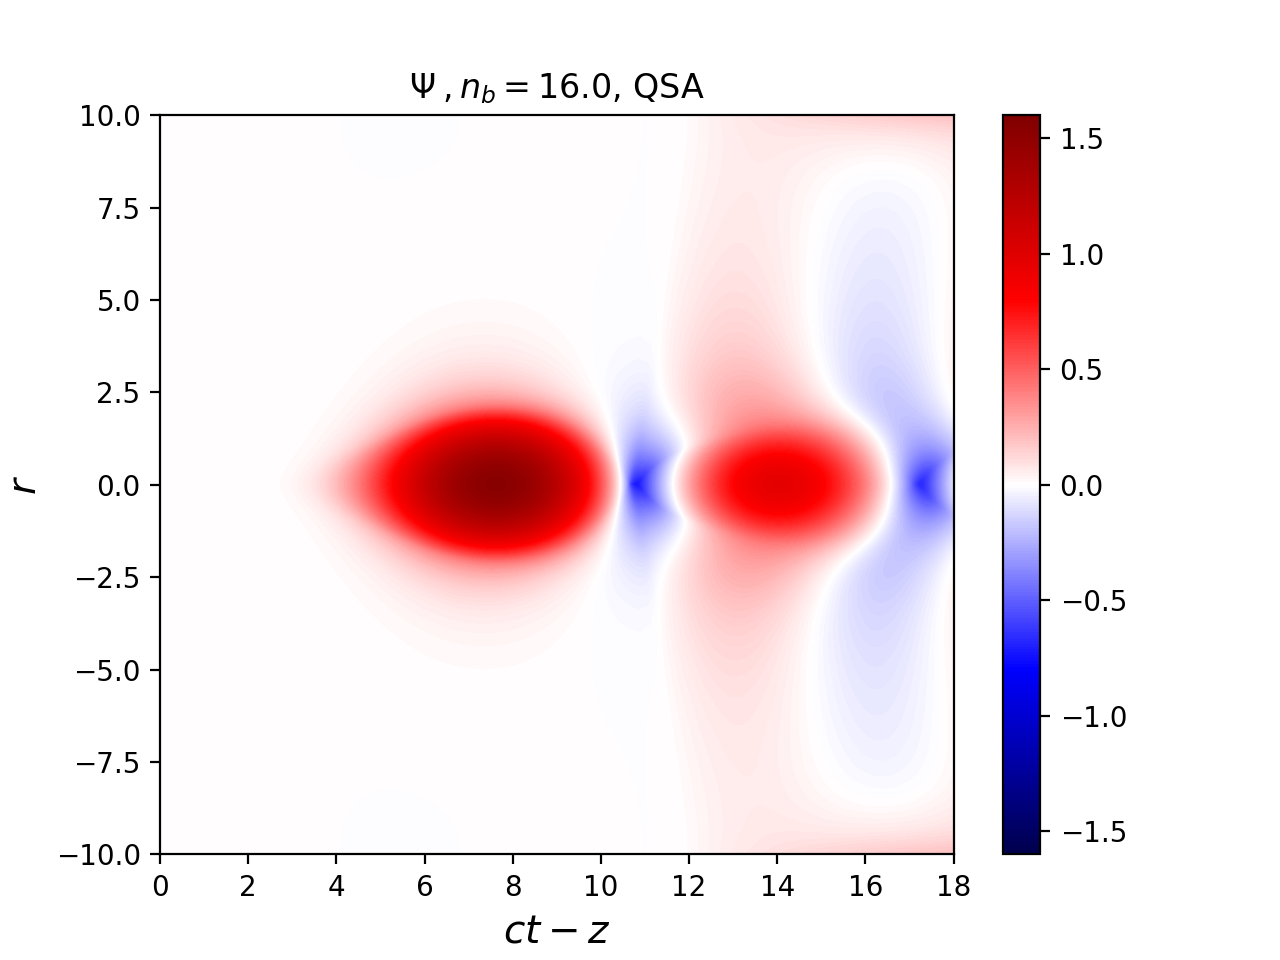

<IPython.core.display.Javascript object>


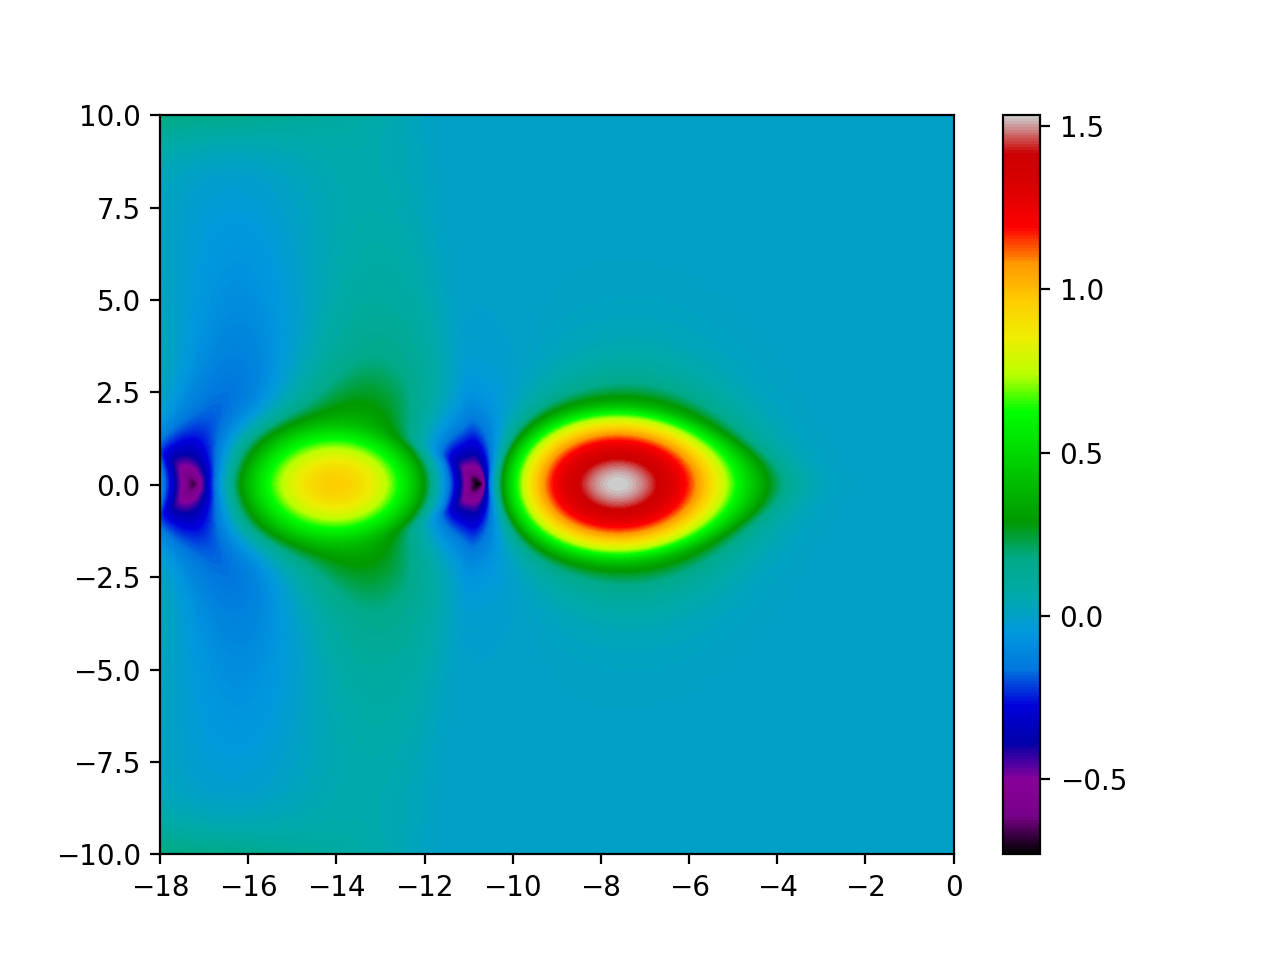

"\nplt.figure()\nvmax = np.max(np.abs(dphi_dxi))*field_dim\n\nEz_ext = np.hstack((dphi_dxi[:,1:][:,::-1], dphi_dxi[:,1:]))\n\nplt.imshow((Ez_ext.T*field_dim), origin='lower', \n           cmap='seismic', extent=ext, vmin=-vmax, vmax=vmax,\n           aspect='auto')\n\nplt.ylabel(r'$r$', fontsize=14)\nplt.xlabel(r'$ct-z$', fontsize=14)\n\nplt.colorbar(label='V/m')\n\nplt.figure()\nvmax = np.max(np.abs(dphi_dr))*field_dim\n\ndphi_dr_ext = np.hstack((-dphi_dr[:,1:][:,::-1], dphi_dr[:,1:]))\n\nplt.imshow(-dphi_dr_ext.T*field_dim, origin='lower', cmap='seismic',\n           vmax=vmax, vmin=-vmax, extent=ext, aspect='auto')\nplt.ylabel(r'$r$', fontsize=14)\nplt.xlabel(r'$ct-z$', fontsize=14)\n\nplt.colorbar(label='V/m')\n"

In [8]:
# psi 0.13926 case1
# psi vmax=0.000588257, vmin=-0.000588257 case 3

plt.figure()
plt.imshow(Phi_new.T, origin='lower', aspect='auto')

#vmax = np.max(np.abs(Phi_new))
psi_ext = np.hstack((Phi_new[:,1:][:,::-1], Phi_new[:,1:]))

plt.imshow((psi_ext.T), origin='lower', 
           cmap='seismic', extent=ext, vmax=1.6, vmin=-1.6,
           aspect='auto')

plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)
plt.title(r'$\Psi \: , n_b = $'+str(n_b)+', QSA')
plt.colorbar()

#plt.savefig('psi_Vika_qsa, '+'n_b = '+str(n_b)+'.jpg')

plt.show()

#############################
plt.figure()

val_ext = np.hstack((Phi_new[:,1:][:,::-1], Phi_new[:,1:]))
ext = np.array([-sim.L_xi, 0, -sim.L_r, sim.L_r ]) # * k_p_inv * 1e6

plt.imshow( val_ext[::-1].T, origin='lower', 
            cmap=plt.cm.nipy_spectral, 
            #vmin = -0.03, vmax=0.03,
            extent=ext, 
            aspect='auto')

#plt.ylabel(r'$r$', fontsize=14)
#plt.xlabel(r'$ct-z$', fontsize=14)

#plt.xlim(-17,0)
plt.colorbar()

plt.show()


'''
plt.figure()
vmax = np.max(np.abs(dphi_dxi))*field_dim

Ez_ext = np.hstack((dphi_dxi[:,1:][:,::-1], dphi_dxi[:,1:]))

plt.imshow((Ez_ext.T*field_dim), origin='lower', 
           cmap='seismic', extent=ext, vmin=-vmax, vmax=vmax,
           aspect='auto')

plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar(label='V/m')

plt.figure()
vmax = np.max(np.abs(dphi_dr))*field_dim

dphi_dr_ext = np.hstack((-dphi_dr[:,1:][:,::-1], dphi_dr[:,1:]))

plt.imshow(-dphi_dr_ext.T*field_dim, origin='lower', cmap='seismic',
           vmax=vmax, vmin=-vmax, extent=ext, aspect='auto')
plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar(label='V/m')
'''

<IPython.core.display.Javascript object>


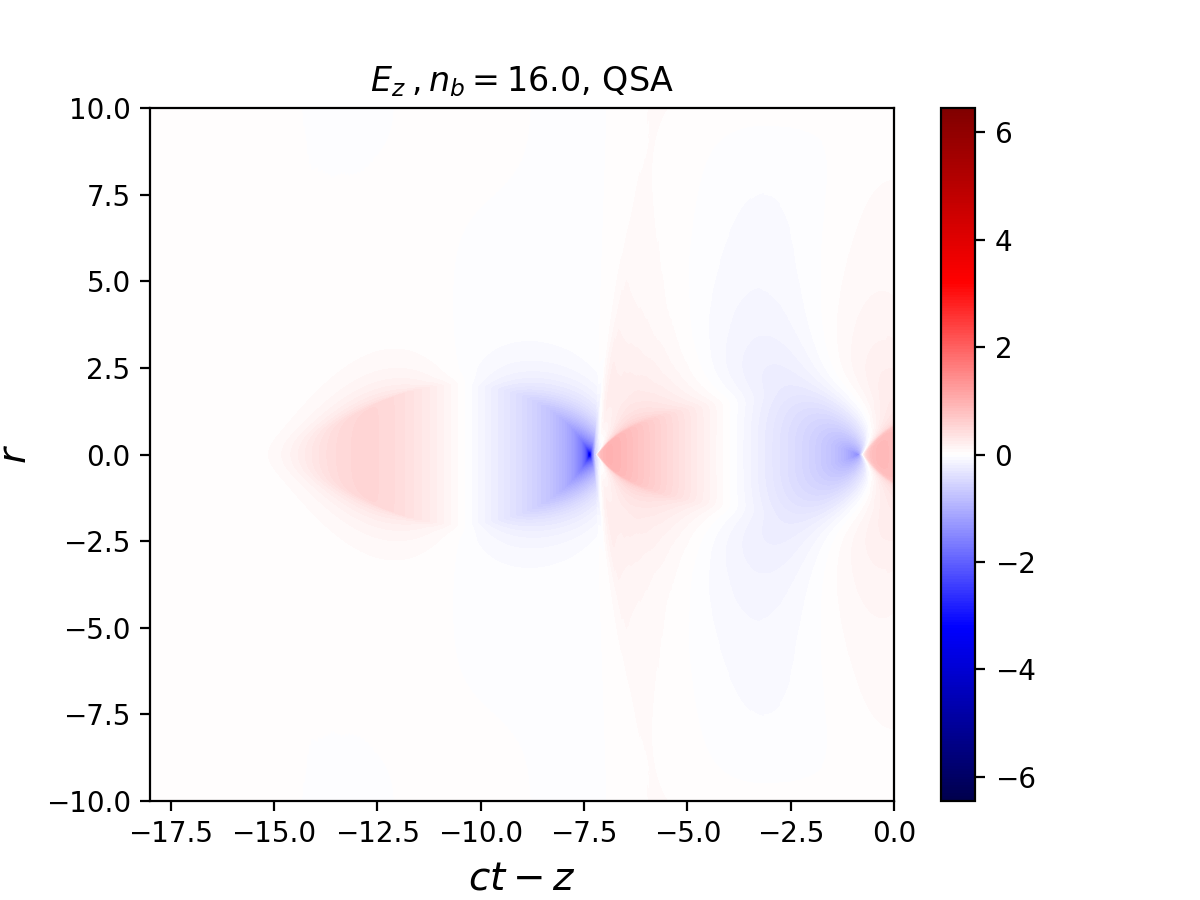

<IPython.core.display.Javascript object>


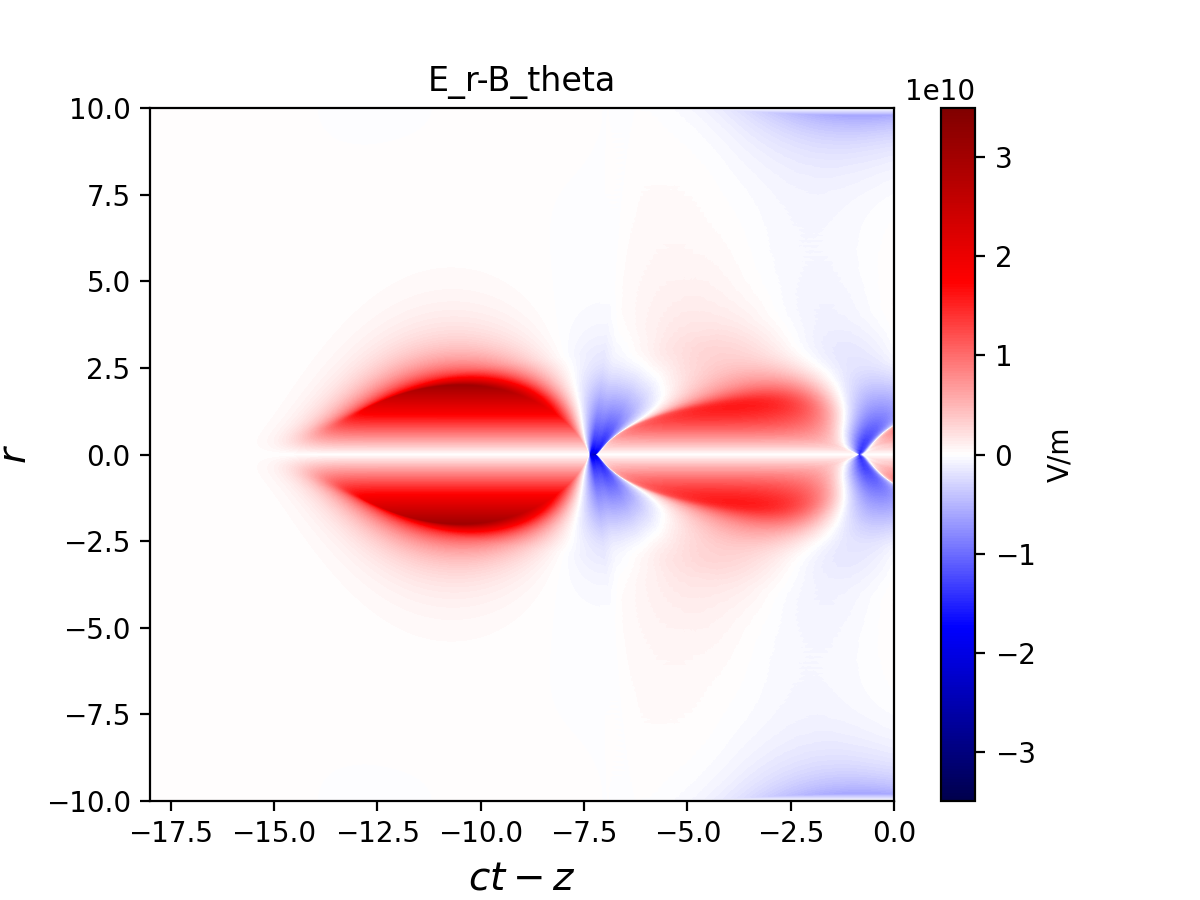

In [9]:
# E_z 0.43 case 1
# E_z 0.000587646864 case 3
plt.figure(figsize=(6,4.5))
vmax = 0.1*np.max(np.abs(dphi_dxi))#*field_dim

Ez_ext = np.hstack((dphi_dxi[:,1:][:,::-1], dphi_dxi[:,1:]))

plt.imshow((Ez_ext.T), origin='lower', 
           cmap='seismic', extent=ext, 
           vmax=6.45,
           vmin=-6.45, 
           aspect='auto')
plt.title(r'$E_z \: , n_b = $'+str(n_b)+', QSA')

plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar()

#plt.savefig('E_z_qsa'+str(n_b)+'.jpg')

plt.figure(figsize=(6,4.5))
vmax = np.max(np.abs(dphi_dr))*field_dim

dphi_dr_ext = np.hstack((dphi_dr[:,1:][:,::-1], dphi_dr[:,1:]))

plt.imshow(-dphi_dr_ext.T*field_dim, origin='lower', cmap='seismic',
           vmax=vmax, vmin=-vmax, extent=ext, aspect='auto')
plt.title('E_r-B_theta')
plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar(label='V/m')

#plt.savefig('E_r-B_theta.jpg')

In [10]:
E_r=-dphi_dr-dAz_dr_xi-dAr_dxi_xi
B_theta=E_r+dphi_dr

<IPython.core.display.Javascript object>


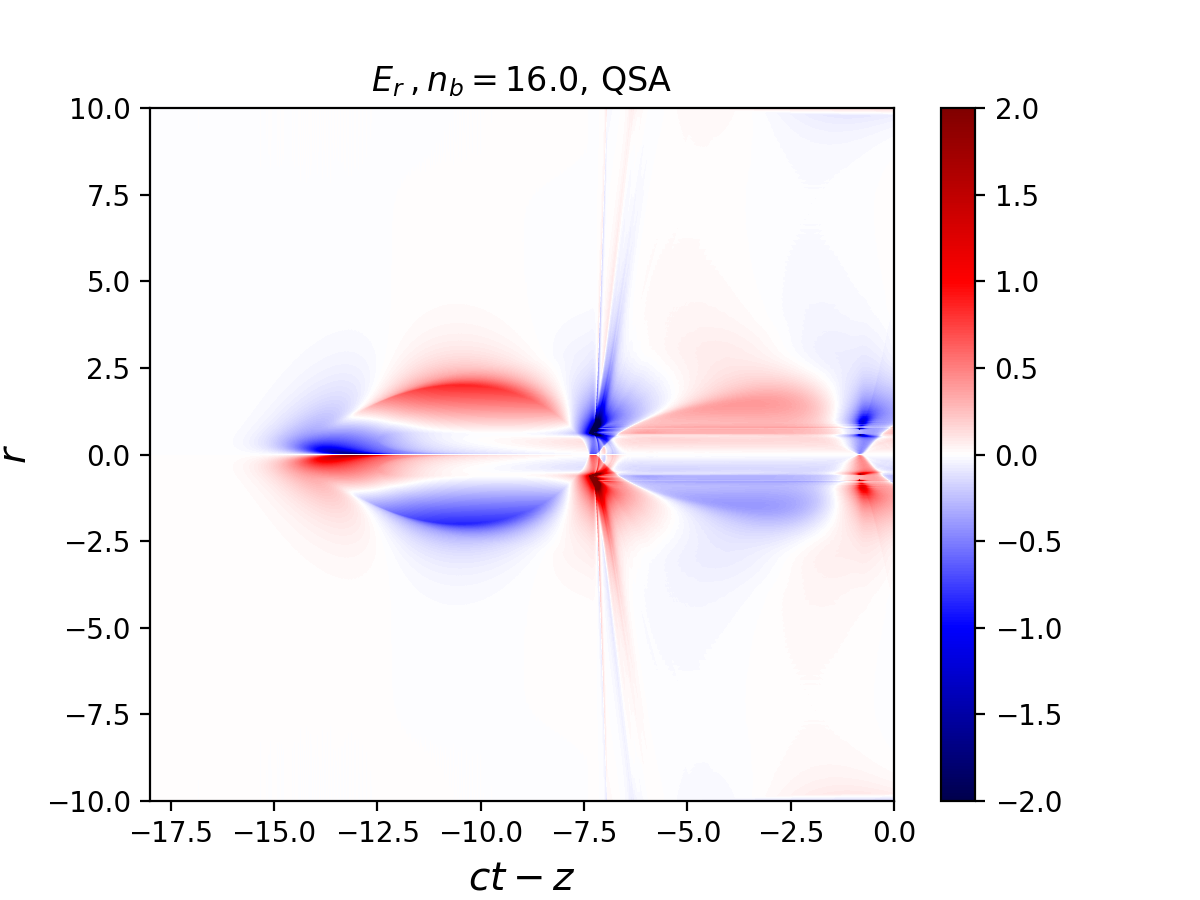

<IPython.core.display.Javascript object>


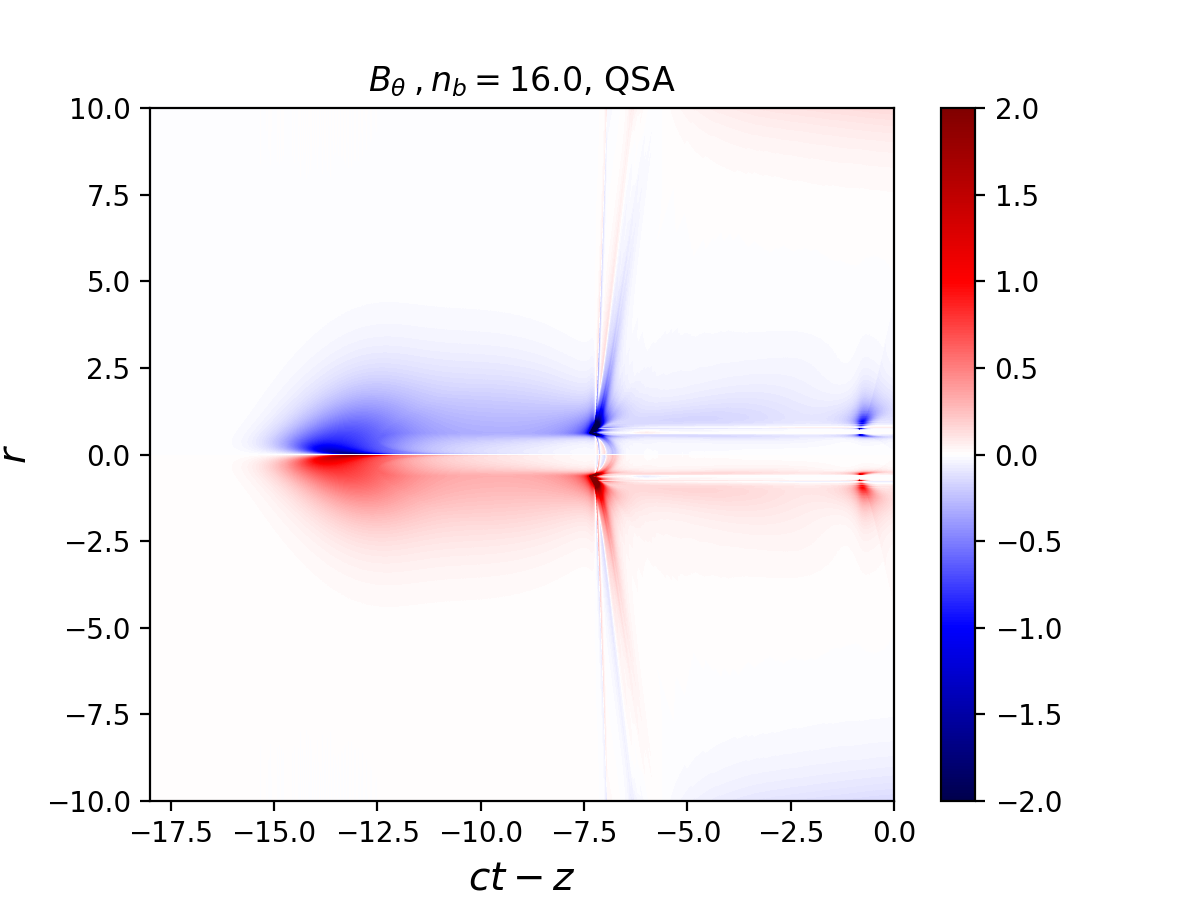

In [11]:
# E_r 0.63 B_theta 0.22 case 1 
# E_r .000854858765 B_theta 0.0008646468 case 1

plt.figure(figsize=(6,4.5))

Er_ext = np.hstack((-E_r[:,1:][:,::-1], E_r[:,1:]))

plt.imshow((Er_ext.T), origin='lower', 
           cmap='seismic', extent=ext, 
           vmax=2,
           vmin=-2, 
           aspect='auto')
plt.title(r'$E_r \: , n_b = $'+str(n_b)+', QSA')

plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar()

#plt.savefig('E_r.jpg')

plt.figure(figsize=(6,4.5))

B_theta_ext = np.hstack((-B_theta[:,1:][:,::-1], B_theta[:,1:]))

plt.imshow((B_theta_ext.T), origin='lower', 
           cmap='seismic', extent=ext, 
           vmax=2,
           vmin=-2, 
           aspect='auto')
plt.title(r'$B_\theta \: , n_b = $'+str(n_b)+', QSA')

plt.ylabel(r'$r$', fontsize=14)
plt.xlabel(r'$ct-z$', fontsize=14)

plt.colorbar()

#plt.savefig('B_theta.jpg')


In [53]:
E_z_linear=np.loadtxt('E_z_Vm.txt', delimiter=",")
E_r_linear=np.loadtxt('E_r_Vm.txt', delimiter=",")
B_theta_linear=np.loadtxt('B_theta_T.txt', delimiter=",")

<IPython.core.display.Javascript object>


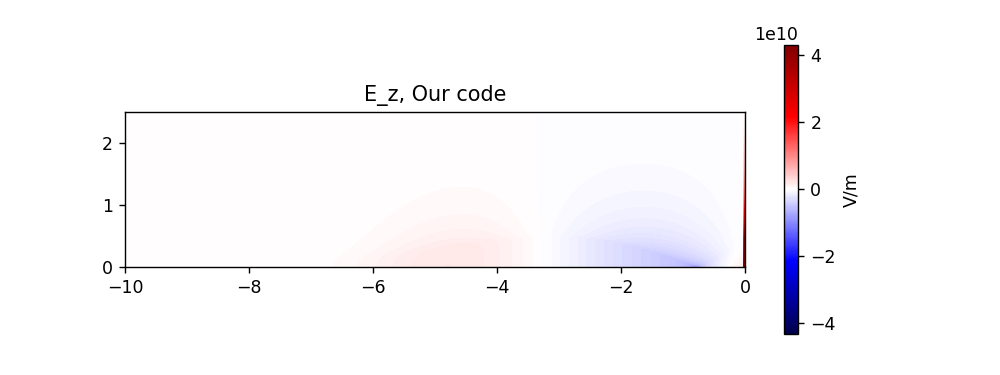

<IPython.core.display.Javascript object>


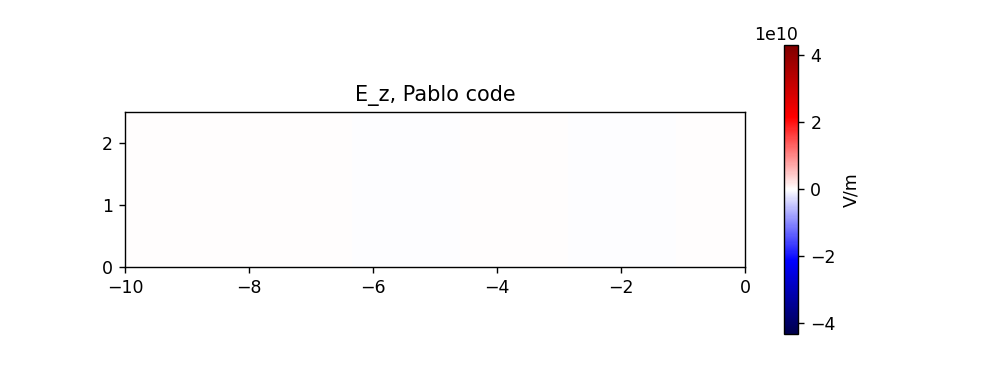

In [64]:
plt.figure(figsize=(8,3))
vmax = 0.4*np.max(np.abs(dphi_dxi))*field_dim
ext1 = np.array([-sim.L_xi, 0, 0, sim.L_r ]) # * k_p_inv * 1e6
plt.imshow(dphi_dxi.T*field_dim, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
plt.title('E_z, Our code')
plt.colorbar(label='V/m')
plt.savefig('E_z, Our code.jpg')


plt.figure(figsize=(8,3))
plt.imshow(E_z_linear, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
plt.title('E_z, Pablo code')
plt.colorbar(label='V/m')
plt.savefig('E_z, Pablo code.jpg')

<IPython.core.display.Javascript object>


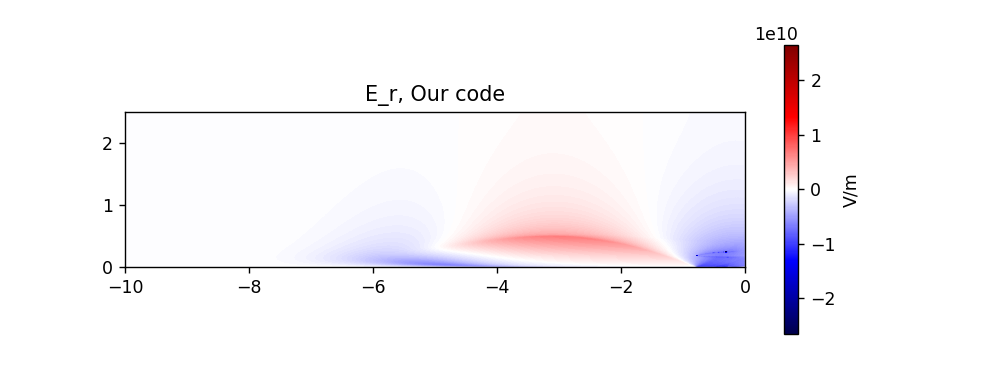

<IPython.core.display.Javascript object>


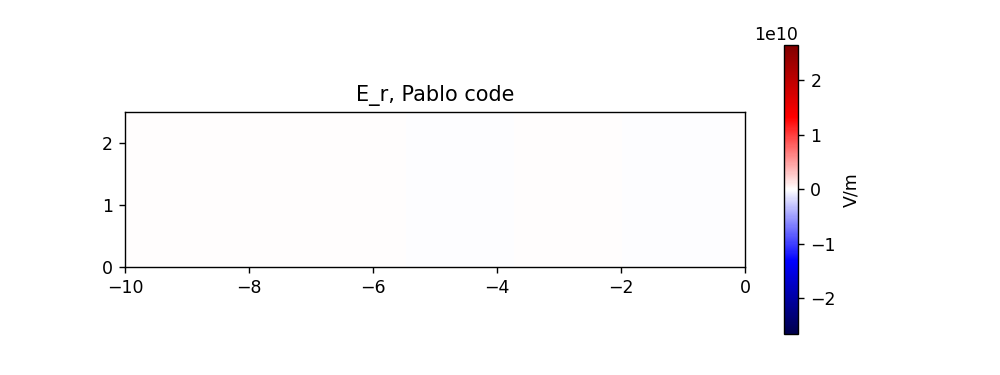

In [66]:
plt.figure(figsize=(8,3))
vmax = 0.1*np.max(np.abs(E_r))*field_dim
plt.imshow(E_r.T*field_dim, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
plt.title('E_r, Our code')
plt.colorbar(label='V/m')
plt.savefig('E_r, Our code.jpg')


plt.figure(figsize=(8,3))
plt.imshow(-E_r_linear, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
plt.title('E_r, Pablo code')
plt.colorbar(label='V/m')
plt.savefig('E_r, Pablo code.jpg')

<IPython.core.display.Javascript object>


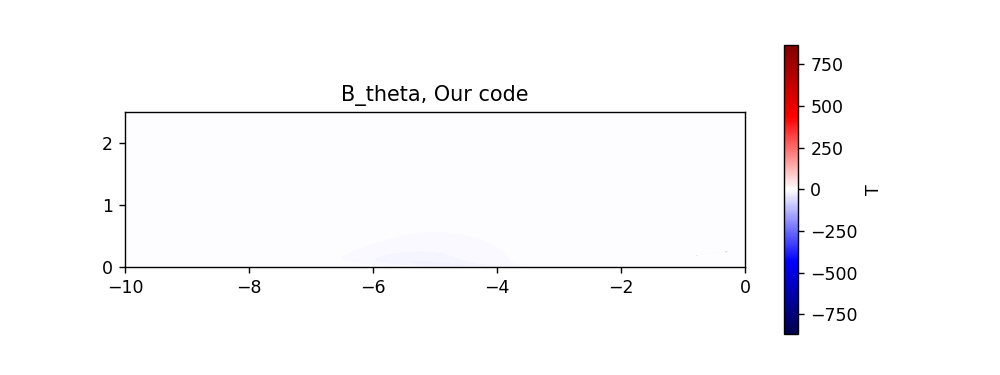

<IPython.core.display.Javascript object>


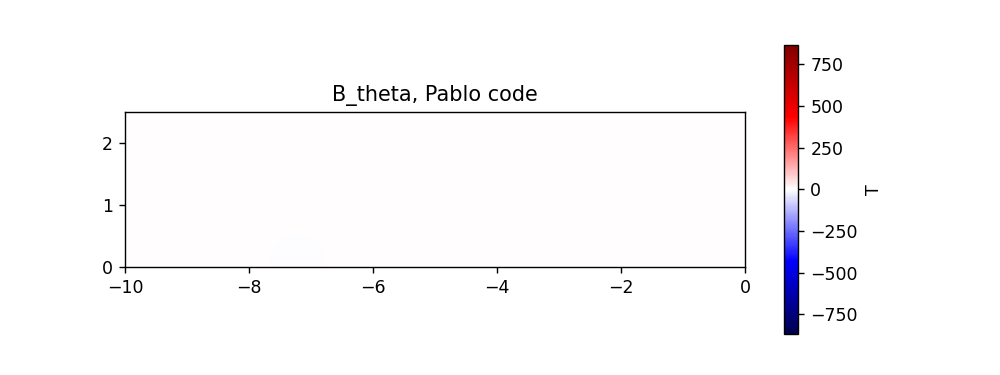

In [57]:
plt.figure(figsize=(8,3))
vmax = np.max(np.abs(B_theta/3/1e8))*field_dim
plt.imshow(B_theta.T*field_dim/3/1e8, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
plt.title('B_theta, Our code')
plt.colorbar(label='T')
plt.savefig('B_theta, Our code.jpg')

plt.figure(figsize=(8,3))
#vmax = 0.4*np.max(np.abs(dphi_dxi))*field_dim
plt.imshow(B_theta_linear, origin='lower', cmap='seismic', extent=ext1, vmax=vmax, vmin=-vmax)
#plt.title('Our code')
plt.title('B_theta, Pablo code')
plt.colorbar(label='T')
plt.savefig('B_theta, Pablo code.jpg')